In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import datasets.dataset_steerableFilter as dataset

In [2]:
def get_batch(dh, batch_size, height, width, filter_size):
    data = dh.GetBatch(filter_size=filter_size, batch_size_=batch_size, sigma=1.0)
    images = data[..., 0].reshape(batch_size, height, width, 1)
    thetas = data[:, 0, 0, 0, 1].reshape(batch_size, 1, 1, 1)   
    labels = data[..., 2].reshape(batch_size, height, width, 1)
    
    return images, thetas, labels

In [3]:
batch_size = 64
height = 64
width = 64
learning_rate = 1e-3

filter_size = 9

# The inputs
images = tf.placeholder(tf.float32, shape=(batch_size, height, width, 1))
labels = tf.placeholder(tf.float32, shape=(batch_size, height, width, 1))
thetas = tf.placeholder(tf.float32, shape=(batch_size, 1, 1, 1))

# The model
## filter-generating network
output = tf.contrib.layers.fully_connected(thetas/np.pi - 1, 64)
output = tf.contrib.layers.fully_connected(output, 128)
filters = tf.contrib.layers.fully_connected(output, filter_size**2, activation_fn=None)

# The dynamic convolution
## im2col on the image: this puts each 9x9 patch of the image into the depth, so we get a [batch_size, height, width, 81] tensor
image_patches = tf.extract_image_patches(images, [1, filter_size, filter_size, 1], [1,1,1,1], [1,1,1,1], padding='SAME')
## Elementwise multiplication of the (spatially broadcasted) filters with the image patches, followed by a summation.
## To do dynamic local filtering instead of dynamic convolution, simply have the filter-generating network
## generate a filter tensor of size [batch_size, height, width, 9*9] instead of [batch_size, 1, 1, 9*9], 
## e.g. with a convolutional network rather than a fully connected one.
predictions = tf.reduce_sum(tf.mul(image_patches, filters), 3, keep_dims=True)

# The loss
loss = tf.reduce_sum(tf.square(predictions - labels), [1,2,3]),  # squared error
batch_loss = tf.reduce_mean(loss) # take the mean over the batch

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(batch_loss)

In [4]:
dh = dataset.DataHandler(image_size=height, mode='standard')
with tf.Session() as sess:
    init = tf.initialize_all_variables()
    sess.run(init)
    
    for step in np.arange(500):
        images_, thetas_, labels_ = get_batch(dh, batch_size, height, width, filter_size)
            
        _, batch_loss_, predictions_, filters_ = \
            sess.run([train_op, batch_loss, predictions, filters],
                     feed_dict={images: images_, thetas: thetas_, labels: labels_})
            
        if step % 10 == 0:
            print((step, batch_loss_))

(0, 569.09814)
(10, 363.83157)
(20, 283.77557)
(30, 252.36868)
(40, 232.57968)
(50, 165.32944)
(60, 162.06079)
(70, 135.36476)
(80, 126.46446)
(90, 89.392258)
(100, 81.802765)
(110, 60.621071)
(120, 48.846153)
(130, 43.490395)
(140, 37.495193)
(150, 32.054432)
(160, 28.275667)
(170, 30.006058)
(180, 20.337526)
(190, 26.67779)
(200, 15.246373)
(210, 18.345329)
(220, 18.599167)
(230, 16.347073)
(240, 13.496849)
(250, 14.923004)
(260, 14.805618)
(270, 11.275234)
(280, 13.642647)
(290, 13.484673)
(300, 11.546764)
(310, 13.374149)
(320, 11.517575)
(330, 9.9248371)
(340, 9.0860825)
(350, 8.1061897)
(360, 13.363266)
(370, 11.385953)
(380, 10.797528)
(390, 7.3658991)
(400, 8.1073704)
(410, 9.8167534)
(420, 9.179821)
(430, 10.120081)
(440, 8.4916668)
(450, 5.4830599)
(460, 5.6911402)
(470, 4.7822647)
(480, 6.0111847)
(490, 4.927897)


('theta: ', 149.5930971306114)


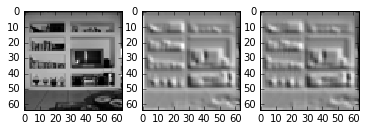

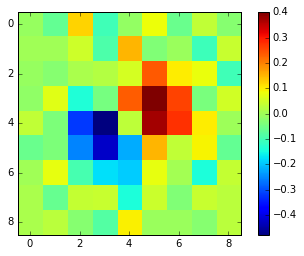

In [5]:
batch_num = 0 # which sample of the batch to visualize

# print the orientation theta
print('theta: ', thetas_[batch_num].squeeze() / (2*np.pi)*360)

# show an input and reconstructed image
plt.subplot(1,3,1)
plt.imshow(images_[batch_num].reshape(height, width), interpolation="nearest", cmap="gray")
# plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(labels_[batch_num].reshape(height, width), interpolation="nearest", cmap="gray")
# plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(predictions_[batch_num].reshape(height, width), interpolation="nearest", cmap="gray")
# plt.colorbar()
plt.show()

# show a dynamically generated filter
plt.imshow(filters_[batch_num,:,:,:].reshape(filter_size, filter_size), interpolation="nearest")
plt.colorbar()
plt.show()